<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

---

## Extract data from Region Of Interest (ROI)

The present jupyter notebook contains the code to extract the zscores, effect size, residuals and timesiries from predefined ROIs. These regions of interest are dependant on the stimulation location and are specified in the metadata file. 

Follow the code step-wise. 

In [1]:
# --- Imports ---
import os
import glob
import nilearn
import numpy as np
import pandas as pd
import nibabel as nib

from numpy import savetxt
from nilearn import plotting
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiLabelsMasker

**Select the hemodynamic response function!** 

To input the corresponding data. 

In [2]:
# --- Path to input / output data ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    spm
    glover
    Two_gammas
    Peak_span
"""
#hrf_function = 'glover'
#hrf_function = 'spm'
hrf_function = 'Two_gammas'
#hrf_function = 'Peak_span'
#hrf_function = 'block'

print('Fetch the data from the first level analysis that used:', hrf_function)

Fetch the data from the first level analysis that used: Two_gammas


**Define input and output directories.**

In [3]:
# --- Init Variables ---
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

# --- Load templates and atlas --- 
template_folder = '/groupshare/traaffneu/preclinimg/templates/'
template_path = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
atlas_img = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_rs.nii')
atlas_labels = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt'
label_info = np.genfromtxt(atlas_labels, skip_header=10, delimiter='\t', dtype=str)
atlas_mask = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii')

# --- Output directories --- 

if hrf_function == 'glover':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
elif hrf_function == 'spm':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
elif hrf_function == 'Two_gammas':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/'
elif hrf_function == 'Peak_span':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/'
elif hrf_function == 'block':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/block/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/block/'
    
else:
    print('Define hrf_function.')

subdirectories = ['mask_ROIs']
zscores_dir = os.path.join(output_dir, 'mask_ROIs/z_scores/')
residuals_dir = os.path.join(output_dir, 'mask_ROIs/residuals/')
real_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/real_timeseries/')

for subdir in subdirectories:
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['z_scores', 'residuals', 'real_timeseries']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

**Let's extract the data!**
1. The 'for' loop iterates through scans. First step is to define the subject numver and load the corresponding scan.
2. Load the outputs of the 1st level analysis. 
3. Take the ROI(s) label in the metadata and find its equivalent index in the atlas. If there are two labels (right/left), they will be conjointly processed. 
4. Create a mask out of the selected ROI(s), fit it to the functional image and extract the signal from the ROI(s).
5. Save outputs.

>Note: extracting each type of signal can be very memory intensive and time consuming. 

In [4]:
# --- Extract data from ROI ---
print(f'Processing HRF: {hrf_function}')

for scan in range(133, 143):         
     
    subj_num=str(df.iloc[scan]['rat.sub'])  #[:-2]
    ses=str(df.iloc[scan]['rat.ses'])
    print('index:', scan)
    print('subj:', subj_num)
    print('ses', ses)

    subj_img_glob = glob.glob(f'/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{subj_num}_ses-{ses}/bold_datasink/commonspace_bold/*/*/*.nii.gz')[0]
    subj_img = nib.load(subj_img_glob)
    
    # --- Load 1-level analysis outputs ---  
    zscores_file = nib.load(first_level_output +f'z_score/z_score_sub-0{subj_num}_ses-{ses}.nii.gz')
    residuals_file = nib.load(first_level_output +f'residuals/residuals_sub-0{subj_num}_ses-{ses}.nii.gz')
    beta_estimates_file = nib.load(first_level_output + f'beta_estimates/beta_sub-0{subj_num}_ses-{ses}.nii.gz')   

    # --- Define the ROI --- 
    labels_dict = {row[-1].strip('"'): int(row[0]) for row in label_info}       # Creates a dictionary with the atlas_label as the key and the label index as the value.
    labels = ['roi_right','roi_left']                                           # Create table with 2 columns, named as in the metadata
    label_indices = []                                                          # create an empty list 
    
    for label in labels:                                                        # Loop iterates through the elements in the labels list.
        atlas_label = df.iloc[scan][label]                                      # Extracts the value in the metadata dataframe, for 1 subject
        print(atlas_label)
        label_indices.append(labels_dict.get(atlas_label))                      # Appends the atlas_label index to the array to search for it later

    # --- Generate the ROI(s) masks --- 
    roi_mask = np.isin(nilearn.image.get_data(atlas_img), label_indices)        # To create the mask, select ROI(s) based on the index
    roi_mask = roi_mask.astype(bool)                                        

    roi_mask_img = nilearn.image.new_img_like(atlas_img, roi_mask)              # Create a mask image out of the roi selected    
    #masker = NiftiMasker(mask_img=roi_mask_img).fit(subj_img)                   # Fit the mask on the functional image
    #masker_stand = NiftiMasker(mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)

    # --- Extract data from the ROI(s)
    
    masker = NiftiLabelsMasker(labels_img=roi_mask_img, mask_img=atlas_mask).fit(subj_img) 
    residuals = masker.fit_transform(residuals_file)
    print("Done residuals")
    real_timeseries = masker.fit_transform(subj_img)
    print("Done real_timeseries")
    z_scores = masker.fit_transform(zscores_file)                             
    print("Done z_scores")

    # --- Save outputs --- 
    savetxt(residuals_dir+f'residuals_sub-0{subj_num}_ses-1.csv', residuals, delimiter=',') 
    savetxt(real_timeseries_dir+f'real_timeseries_sub-0{subj_num}_ses-1.csv', real_timeseries, delimiter=',') 
    savetxt(zscores_dir+f'zscores_sub-0{subj_num}_ses-1.csv', z_scores, delimiter=',')     
    
    #test
    # savetxt(f'/project/4180000.19/multirat_stim/ROI_data/timeseries/{hrf_function}/timeseries_sub-0{subj_num}_ses-1.csv', real_timeseries, delimiter=',') 
    # savetxt(f'/project/4180000.19/multirat_stim/ROI_data/residuals/{hrf_function}/residuals_sub-0{subj_num}_ses-1.csv', residuals, delimiter=',') 
      
    print("Done Saving")

Processing HRF: Two_gammas
index: 133
subj: 201500
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done Saving
index: 134
subj: 201501
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done Saving
index: 135
subj: 201502
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done Saving
index: 136
subj: 201503
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done Saving
index: 137
subj: 201504
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done Saving
index: 138
subj: 201505
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done Saving
index: 139
subj: 201506
ses 1
Primary Somatosensory Cortex Barrel field-R
nan
Done residuals
Done real_timeseries
Done z_scores
Done 

In [14]:
print(z_scores)

[[-0.12212982]]


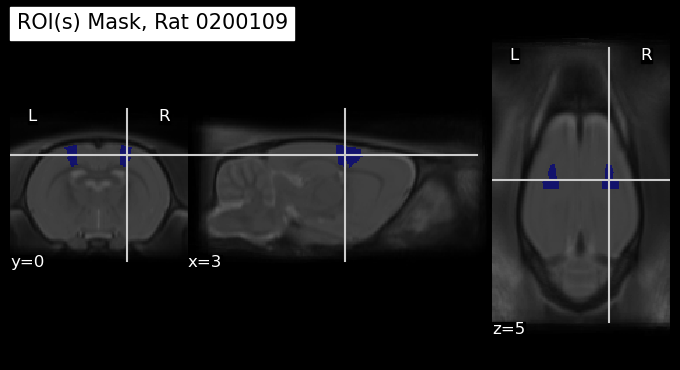

In [12]:
# --- Check the mask --- 
plotting.plot_roi(roi_mask_img, bg_img=template_path, title=f"ROI(s) Mask, Rat 0{subj_num}")

In [24]:
# original script
subj_num= '200100'
all_zscores = []

new_zscores = pd.read_csv(f'/project/4180000.19/multirat_stim/test_zscores/zscores_sub-0{subj_num}_ses-1.csv')
stand_zscores = (new_zscores.mean(axis=0) - new_zscores.mean(axis=0).mean()) / new_zscores.mean(axis=0).std()

print(new_zscores)


Empty DataFrame
Columns: [1.112421109576892420e+01, 1.040351108302501082e+01, 7.161089645204873122e+00, 5.528351334883335078e+00, 7.576355091368899508e+00, 8.224112700650049845e+00, 1.012801035358179824e+01, 9.044043471631365350e+00, 1.126038292786779671e+01, 1.108579690016642694e+01, 1.068074128262216860e+01, 9.947728940696000777e+00, 1.126158325257297399e+01, 1.118181200359839700e+01, 1.081134129036839475e+01, 1.136256715131086281e+01, 1.160883797695333008e+01, 1.142819174227583012e+01, 1.199985108342339224e+01, 1.127427462097852207e+01, 1.149785956709648183e+01, 1.237411405320853497e+01, 1.121719897101185914e+01, 1.159263860778627730e+01, 1.144389294978293492e+01, 1.123637505605710984e+01, 1.141359590986099093e+01, 1.121061182300111447e+01, 1.122842160038428361e+01, 1.115170204032942713e+01, 8.766144586326230836e+00, 7.991190454885582994e+00, 7.140103538356913582e+00, 9.236805627639324001e+00, 8.454131593831153424e+00, 7.707820924039736177e+00, 9.727199858894058693e+00, 9.0011710799

In [13]:
# + labels_img=roi_mask_img, mask_img=atlas_mask
subj_num= '200100'
new_zscores = pd.read_csv(f'/project/4180000.19/multirat_stim/test_zscores/zscores_sub-0{subj_num}_ses-1.csv')
print(new_zscores)

Empty DataFrame
Columns: [8.481280682828835182e+00]
Index: []
